# Style Transfer on ONNX Models with OpenVINO™

![Neural Style Transfer network output](https://user-images.githubusercontent.com/77325899/147354137-4fc9e79e-0195-4927-9608-0e3f17973d75.png)

This notebook demonstrates [Fast Neural Style Transfer](https://github.com/onnx/models/tree/master/vision/style_transfer/fast_neural_style) on ONNX models with OpenVINO. Style Transfer models mix the content of an image with the style of another image. 

This notebook uses five pre-trained models, for the following styles: Mosaic, Rain Princess, Candy, Udnie and Pointilism. The models are from the [ONNX Model Repository](https://github.com/onnx/models) and are based on the research paper [Perceptual Losses for Real-Time Style Transfer and Super-Resolution](https://arxiv.org/abs/1603.08155) by Justin Johnson, Alexandre Alahi and Li Fei-Fei.

## Preparation

### Imports

In [1]:
import sys
from enum import Enum
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML, FileLink, clear_output, display
from openvino.runtime import Core, PartialShape
from yaspin import yaspin

sys.path.append("../utils")
from notebook_utils import download_file

### Download Models

The `Style` Enum lists the supported styles with `url`, `title` and `model_path` properties. Models for all supported styles will be downloaded to `MODEL_DIR` if they have not been downloaded before.

In [2]:
BASE_URL = "https://github.com/onnx/models/raw/main/vision/style_transfer/fast_neural_style/model"
MODEL_DIR = "model"


class Style(Enum):
    MOSAIC = "mosaic"
    RAIN_PRINCESS = "rain-princess"
    CANDY = "candy"
    UDNIE = "udnie"
    POINTILISM = "pointilism"

    def __init__(self, *args):
        self.model_path = Path(f"{self.value}-9.onnx")
        self.title = self.value.replace("-", " ").title()
        self.url = f"{BASE_URL}/{self.model_path}"

In [3]:
for style in Style:
    if not Path(f"{MODEL_DIR}/{style.model_path}").exists():
        download_file(style.url, directory=MODEL_DIR)

model\mosaic-9.onnx:   0%|          | 0.00/6.42M [00:00<?, ?B/s]

model\rain-princess-9.onnx:   0%|          | 0.00/6.42M [00:00<?, ?B/s]

model\candy-9.onnx:   0%|          | 0.00/6.42M [00:00<?, ?B/s]

model\udnie-9.onnx:   0%|          | 0.00/6.42M [00:00<?, ?B/s]

model\pointilism-9.onnx:   0%|          | 0.00/6.42M [00:00<?, ?B/s]

### Load an Image

Load an image with OpenCV and convert it to `RGB`. The style transfer model will be resized to the image shape. This gives the most detailed results, but for larger images, inference will take longer and use more memory. The `resize_to_max` function optionally resizes the image to a maximum size. 

In [4]:
IMAGE_FILE = "data/coco_square.jpg"
image = cv2.cvtColor(cv2.imread(IMAGE_FILE), cv2.COLOR_BGR2RGB)


def resize_to_max(image: np.ndarray, max_side: int) -> np.ndarray:
    """
    Resize image to an image where the largest side has a maximum length of max_side
    while keeping aspect ratio. Example: if an original image has width and height of (1000, 500)
    and max_side is 300, the resized image will have a width and height of (300, 150).

    :param image: Array of image to resize
    :param max_side: Maximum length of largest image side
    :return: Resized image
    """
    if max(image.shape) <= max_side:
        new_image = image
    else:
        index = np.argmax(image.shape)
        factor = max_side / image.shape[index]
        height, width = image.shape[:2]
        new_height, new_width = int(factor * height), int(factor * width)
        new_image = cv2.resize(image, (new_width, new_height))
    return new_image


# Uncomment the line below to resize large images to a max side length to improve inference speed.
# image = resize_to_max(image=image, max_side=1024)

## Do Inference and Show Results

For all five models: do inference, convert the result to an 8-bit image, show the results, and save the results to a disk.

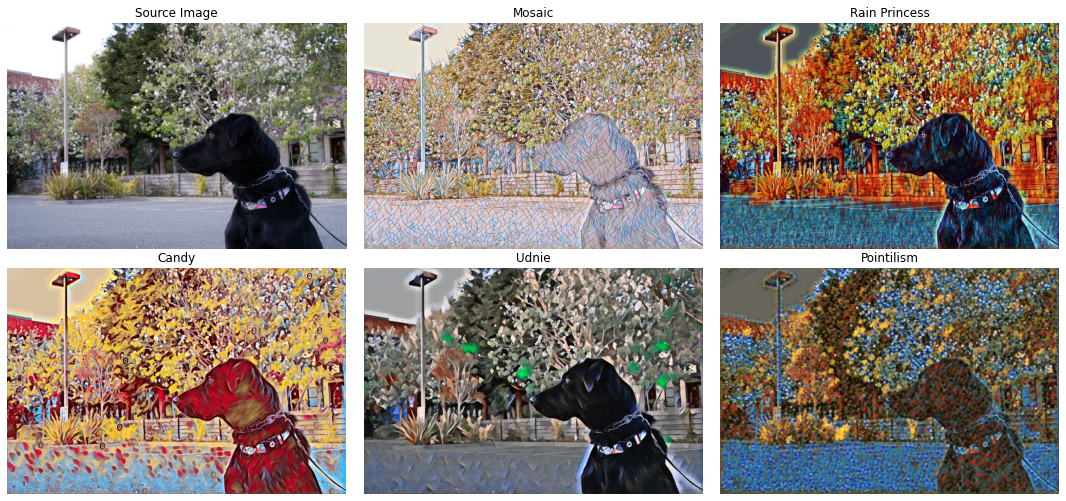

In [5]:
# Set SAVE_RESULTS to False to disable saving the result images.
SAVE_RESULTS = True

# Find reasonable dimensions for a matplotlib plot.
wh_ratio = image.shape[1] / image.shape[0]
figwidth = 15
figheight = (figwidth * 0.75) // wh_ratio

# Create a matplotlib plot and show the source image.
fig, ax = plt.subplots(2, 3, figsize=(figwidth, figheight))
axs = ax.ravel()
axs[0].imshow(image)
axs[0].set_title("Source Image")
axs[0].axis("off")

# Create a `Core` instance, prepare an output folder.
ie = Core()
output_folder = Path("output")
output_folder.mkdir(exist_ok=True)

# Transpose the input image to network dimensions and extract the name and the shape of the image.
input_image = np.expand_dims(image.transpose(2, 0, 1), axis=0)
image_name = Path(IMAGE_FILE).stem
image_shape_str = f"{image.shape[1]}x{image.shape[0]}"

file_links = []
for i, style in enumerate(Style):
    # Load the model and get model info.
    model = ie.read_model(model=Path(MODEL_DIR) / style.model_path)
    input_key = model.input(0)

    # Reshape the network to the image shape and load the network to a device.
    model.reshape({input_key: PartialShape([1, 3, image.shape[0], image.shape[1]])})
    compiled_model = ie.compile_model(model=model, device_name="CPU")
    output_key = compiled_model.output(0)
    # Do inference.
    with yaspin(text=f"Doing inference on {style.title} model") as sp:
        result = compiled_model([input_image])[output_key]
        sp.ok("✔")

    # Convert the inference result to the image shape and apply postprocessing.
    # Postprocessing is described in the model documentation:
    # https://github.com/onnx/models/tree/master/vision/style_transfer/fast_neural_style
    result = result.squeeze().transpose(1, 2, 0)
    result = np.clip(result, 0, 255).astype(np.uint8)

    # Show the result.
    axs[i + 1].imshow(result)
    axs[i + 1].set_title(style.title)
    axs[i + 1].axis("off")

    # (optional) Save the results to a disk.
    if SAVE_RESULTS:
        image_path = f"{image_name}_{style.model_path.stem}_{image_shape_str}.png"
        output_path = output_folder / image_path
        cv2.imwrite(str(output_path), cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
        file_link = FileLink(output_path, result_html_prefix=f"{style.title} image: ")
        file_link.html_link_str = "<a href='%s' download>%s</a>"
        file_links.append(file_link)

    del model
    del compiled_model

clear_output(wait=True)
fig.tight_layout()
plt.show()

if SAVE_RESULTS:
    output_path = output_folder / f"{image_name}_{image_shape_str}_style_transfer.jpg"
    fig.savefig(str(output_path), dpi=300, bbox_inches="tight", pad_inches=0.1)
    file_link = FileLink(output_path, result_html_prefix="Overview image: ")
    file_link.html_link_str = "<a href='%s' download>%s</a>"
    file_links.append(file_link)
    display(HTML("Saved image files:"))
    for file_link in file_links:
        display(HTML(file_link._repr_html_()))